In [1]:
# 使用的是 FLANN (Fast Library for Approximate Nearest Neighbors) 匹配算法 与 SIFT (Scale-Invariant Feature Transform) 特征提取算法 的组合，即 FLANN + SIFT。

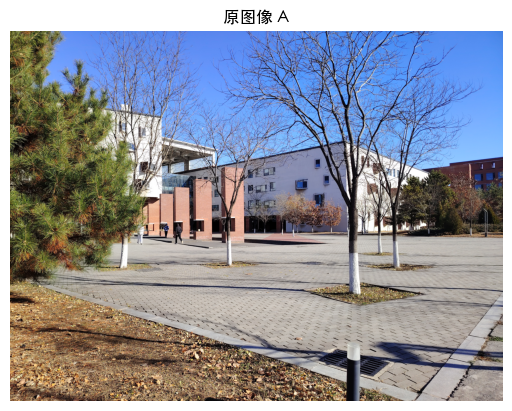

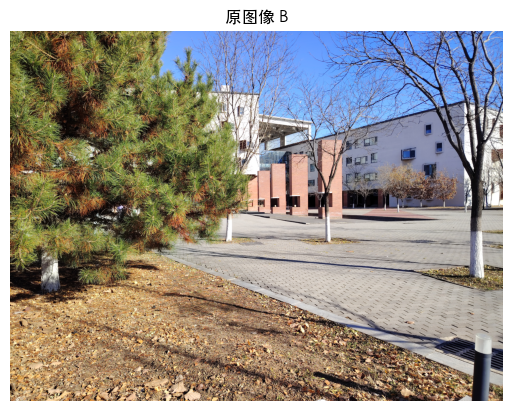

[detectAndDescribe] 检测到特征点数量: 130588, 耗时: 1.8332 秒
[detectAndDescribe] 检测到特征点数量: 163995, 耗时: 1.4222 秒
图像 A 特征点数量: 130588
图像 B 特征点数量: 163995


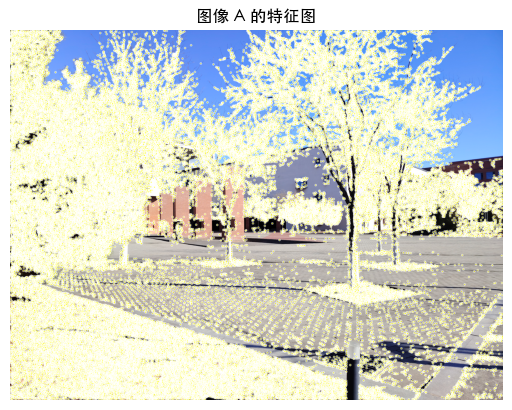

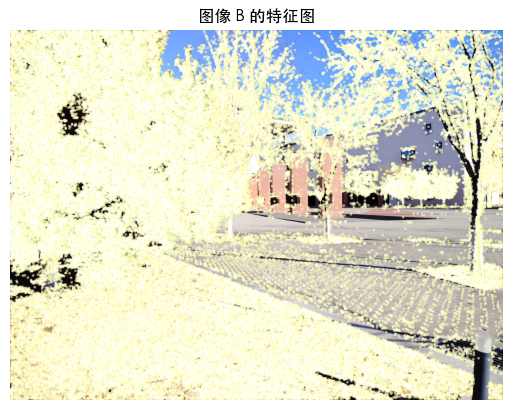

[match_keypoints_with_flann] 初始匹配数: 130588, 通过比率测试后: 20337, 平均匹配距离: 141.57, 耗时: 3.1984 秒
通过 FLANN + Lowe 比率测试获得的有效匹配点数量：20337


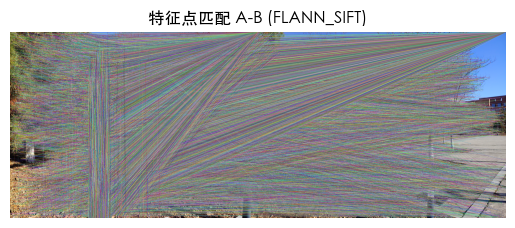

[stitch_images] 内点数量: 10149/20337, 内点比例: 0.50


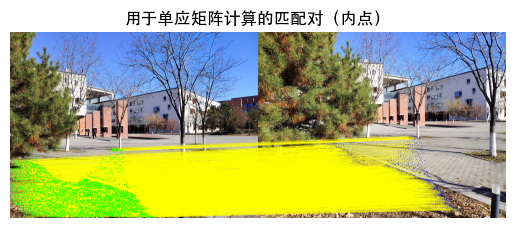

[stitch_images] 拼接完成，耗时: 0.7347 秒


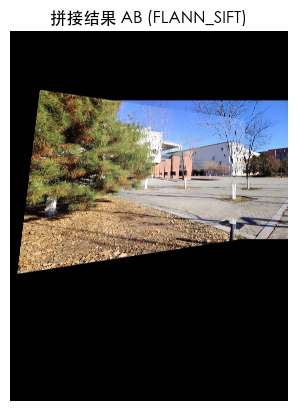

拼接结果已保存至: ./output_FLANN/stitched_FLANN_SIFT_3_4.jpg


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time  # === 新增代码示例：如果需要统计耗时，可以导入 time

# 设置全局字体（这里以 SimHei 为例）
plt.rcParams['font.sans-serif'] = ['STHeiti']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ============================
# 配置参数
# ============================
imageA_path = "../datasets/new_data/3.jpg"  # 图像 A 的路径
imageB_path = "../datasets/new_data/4.jpg"  # 图像 B 的路径

distance_ratio = 0.75
ransac_threshold = 5
min_matches_required = 4
gaussian_kernel_size = (7, 7)

def show_image(image, title="Image"):
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detectAndDescribe(image):
    """
    进行高斯模糊 + SIFT 特征点检测和描述。
    """
    start_time = time.time()  # === 新增代码示例：记录开始时间

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.GaussianBlur(gray, gaussian_kernel_size, 0)

    descriptor = cv2.SIFT_create()
    kps, des = descriptor.detectAndCompute(denoised, None)
    kps_float = np.float32([kp.pt for kp in kps])

    end_time = time.time()  # === 新增代码示例：记录结束时间
    print(f"[detectAndDescribe] 检测到特征点数量: {len(kps)}, 耗时: {end_time - start_time:.4f} 秒")

    return (kps, kps_float, des)

def match_keypoints_with_flann(desA, desB):
    """
    使用 FLANN + KNN + Lowe's ratio 进行匹配
    """
    start_time = time.time()  # === 新增代码示例

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    raw_matches = matcher.knnMatch(desA, desB, 2)

    good_matches = []
    matches = []

    distances = []  # === 新增代码示例：用于统计匹配距离
    for m, n in raw_matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append([m])
            matches.append((m.queryIdx, m.trainIdx))
            distances.append(m.distance)  # === 新增代码示例：记录距离

    # === 新增代码示例：计算平均匹配距离
    avg_dist = np.mean(distances) if len(distances) > 0 else -1

    end_time = time.time()
    print(f"[match_keypoints_with_flann] 初始匹配数: {len(raw_matches)}, "
          f"通过比率测试后: {len(good_matches)}, "
          f"平均匹配距离: {avg_dist:.2f}, "
          f"耗时: {end_time - start_time:.4f} 秒")

    return good_matches, matches

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    if not good_matches or not isinstance(good_matches[0], list):
        print("Error: good_matches 格式不正确，应为包含 DMatch 对象的列表列表。")
        return None

    vis = cv2.drawMatchesKnn(imageB, kpsB, imageA, kpsA, 
                             good_matches, None, 
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return vis

def stitch_images(center_image, align_image, center_kps_float, align_kps_float, matches):
    """
    根据 RANSAC 计算单应矩阵并拼接，同时统计内点数量与比例。
    """
    if len(matches) <= min_matches_required:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None

    start_time = time.time()  # === 新增代码示例

    pts_center = np.float32([center_kps_float[i] for (i, _) in matches])
    pts_align = np.float32([align_kps_float[j] for (_, j) in matches])

    H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)
    if status is None:
        print("[stitch_images] RANSAC 计算失败。")
        return None

    # === 新增代码示例：统计内点
    inlier_count = np.sum(status)
    total_count = len(matches)
    inlier_ratio = inlier_count / float(total_count)
    print(f"[stitch_images] 内点数量: {inlier_count}/{total_count}, "
          f"内点比例: {inlier_ratio:.2f}")

    inlier_pts_center = pts_center[status.ravel() == 1]
    inlier_pts_align = pts_align[status.ravel() == 1]

    combined_image = np.hstack((center_image, align_image))
    offset = center_image.shape[1]
    for pt_center, pt_align in zip(inlier_pts_center, inlier_pts_align):
        pt_center = (int(pt_center[0]), int(pt_center[1]))
        pt_align = (int(pt_align[0] + offset), int(pt_align[1]))
        cv2.circle(combined_image, pt_center, 5, (0, 255, 0), -1)
        cv2.circle(combined_image, pt_align, 5, (255, 0, 0), -1)
        cv2.line(combined_image, pt_center, pt_align, (0, 255, 255), 1)
    show_image(combined_image, "用于单应矩阵计算的匹配对（内点）")

    # 执行拼接
    height_center, width_center = center_image.shape[:2]
    canvas_size = (height_center * 2, width_center * 2)
    translation_dist = (canvas_size[1] // 4, canvas_size[0] // 4)
    H_translation = np.array([[1, 0, translation_dist[0]],
                              [0, 1, translation_dist[1]],
                              [0, 0, 1]], dtype=np.float32)

    result = cv2.warpPerspective(center_image, H_translation, canvas_size)
    H_combined = H_translation @ H
    warped_align = cv2.warpPerspective(align_image, H_combined, canvas_size)
    result = np.maximum(result, warped_align)

    end_time = time.time()
    print(f"[stitch_images] 拼接完成，耗时: {end_time - start_time:.4f} 秒")

    return result

def show_keypoints(image, keypoints, title="Keypoints"):
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 8, (255, 255, 255), 2)
        cv2.circle(image_with_keypoints, (x, y), 4, (0, 255, 255), -1)
    show_image(image_with_keypoints, title)

if __name__ == "__main__":
    imageA = cv2.imread(imageA_path)
    imageB = cv2.imread(imageB_path)

    if imageA is None or imageB is None:
        print("Error: Could not load one or both images.")
    else:
        show_image(imageA, "原图像 A")
        show_image(imageB, "原图像 B")

        # 特征点检测与描述
        kpsA, kps_floatA, desA = detectAndDescribe(imageA)
        kpsB, kps_floatB, desB = detectAndDescribe(imageB)

        # 输出特征点数量（可选，再次展示）
        print(f"图像 A 特征点数量: {len(kpsA)}")
        print(f"图像 B 特征点数量: {len(kpsB)}")

        # 显示特征点
        show_keypoints(imageA, kpsA, "图像 A 的特征图")
        show_keypoints(imageB, kpsB, "图像 B 的特征图")

        # 匹配
        good_matches_AB, matches_AB = match_keypoints_with_flann(desA, desB)
        print(f"通过 FLANN + Lowe 比率测试获得的有效匹配点数量：{len(good_matches_AB)}")

        # 显示匹配结果
        vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
        if vis_AB is not None:
            show_image(vis_AB, "特征点匹配 A-B (FLANN_SIFT)")

        # 图像拼接
        stitchedAB = stitch_images(imageA, imageB, kps_floatA, kps_floatB, matches_AB)
        if stitchedAB is not None:
            show_image(stitchedAB, "拼接结果 AB (FLANN_SIFT)")

            # 保存拼接结果
            baseA = os.path.basename(imageA_path)[-7:-4]
            baseB = os.path.basename(imageB_path)[-7:-4]
            output_filename = f"./output_FLANN/stitched_FLANN_SIFT_{baseA}_{baseB}.jpg"
            os.makedirs('./output_FLANN', exist_ok=True)
            cv2.imwrite(output_filename, stitchedAB)
            print(f"拼接结果已保存至: {output_filename}")
        else:
            print("由于匹配点不足，拼接失败。")